---
# WA origin/destination files
---
Determine oil type weighting for tank traffic in MIDOSS monte-carlo by cataloguing information in Department of Ecology's recorded marine terminal transfers for 2018.  Only transfers greater than 1000 L are required to be documented. The data is sorted into `origin` and `destination` dictionaries, where `origin` indicates oil export and `destination` indicates oil import.  Imports and exports are catalogued by vessel and oil types used in this study. 

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte_carlo
```
To deactivate an active environment, use
```
 conda deactivate
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

In [2]:
# User inputs
file_dir  = '/Users/rmueller/Data/MIDOSS/DeptOfEcology/'
file_name = 'MuellerTrans4-30-20.xlsx'

# This is the precision used to calculate oil type weights 
# Trial and error showed that a precision of 2 is neccessary for weights
# to sum to 1.0
precision = 2

In [3]:
# Import columns are: (G) Deliverer, (H) Receiver, (O) Region, (P) Product, 
#                     (Q) Quantity in Gallons, (R) Transfer Type (oiling, Cargo, or Other)', 
#                     (w) DelivererTypeDescription, (x) ReceiverTypeDescription 
df = pd.read_excel(f'{file_dir}{file_name}',sheet_name='Vessel Oil Transfer', 
                   usecols="G,H,P,Q,R,W,X")

# housekeeping: Force one name per marine transfer site
df = df.replace(
    to_replace = 'US Oil Tacoma ',
    value = 'U.S. Oil & Refining'
)
df = df.replace(
    to_replace = 'TLP',
    value = 'TLP Management Services LLC (TMS)'
)

# rename 'Maxum (Rainer Petroleum)' and 'Shell Oil LP Seattle Distribution Terminal' as 'Kinder Morgan Liquids Terminal - Harbor Island'
df['Deliverer'] = df['Deliverer'].replace(
    ['Maxum (Rainer Petroleum)','Shell Oil LP Seattle Distribution Terminal'], 
    'Kinder Morgan Liquids Terminal - Harbor Island'
)
df['Receiver'] = df['Receiver'].replace(
    ['Maxum (Rainer Petroleum)','Shell Oil LP Seattle Distribution Terminal'],
    'Kinder Morgan Liquids Terminal - Harbor Island'
)

# Rename Nustar Energy Tacoma -> Phillips 66 Tacoma
df['Deliverer'] = df['Deliverer'].replace(
    ['Nustar Energy Tacoma'], 
    'Phillips 66 Tacoma Terminal'
)
df['Receiver'] = df['Receiver'].replace(
    ['Nustar Energy Tacoma'],
    'Phillips 66 Tacoma Terminal'
)

## Create a list of all terminals included in the dataset, together with Region 
(so we can isolate Salish Sea) 

In [4]:
# The following list includes facilities used in Casey's origin/destination analysis 
# with names matching the Dept. of Ecology (DOE) database.  
# For example, the shapefile "Maxum Petroleum - Harbor Island Terminal" is labeled as 'Maxum (Rainer Petroleum)'
# in the DOE database.  I use the Ecology language here and will need to translate to Shapefile speak 
facility_names = [ 'BP Cherry Point Refinery', 'Shell Puget Sound Refinery', 
                  'Tidewater Snake River Terminal','Nustar Energy Tacoma', 
                   'SeaPort Sound Terminal', 'Tesoro Vancouver Terminal','Phillips 66 Ferndale Refinery', 
                   'Phillips 66 Tacoma Terminal', 'Andeavor Anacortes Refinery (formerly Tesoro)',
                   'Tesoro Port Angeles Terminal','U.S. Oil & Refining','Naval Air Station Whidbey Island (NASWI)',
                   'NAVSUP Manchester', 'Alon Asphalt Company (Paramount Petroleum)', 'Kinder Morgan Liquids Terminal - Harbor Island',
                   'Tesoro Pasco Terminal', 'REG Grays Harbor, LLC', 'Tidewater Vancouver Terminal',
                   'TLP Management Services LLC (TMS)']

# define vessel and oil types to include in .yaml file
vessel_types = ['atb', 'barge', 'tanker']
oil_types    = ['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']
data_types    = ['total_gallons', 'fraction_of_total', 'number_of_transfers']

## Create name lists for the DOE oil types used in our monte-carlo oil categories

In [5]:
# identify all names of oils in DOE database that are attributed to our oil types
oil_classification = {}
for oil in oil_types:
    oil_classification[oil] = []

[nrows,ncols] = df.shape
for row in range(nrows):
    if 'CRUDE' in df.Product[row] and df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(df.Product[row])
    elif 'BAKKEN' in df.Product[row] and df.Product[row] not in oil_classification['akns']:
        oil_classification['akns'].append(df.Product[row])
    elif 'BUNKER' in df.Product[row] and df.Product[row] not in oil_classification['bunker']:
        oil_classification['bunker'].append(df.Product[row])
    elif 'BITUMEN' in df.Product[row] and df.Product[row] not in oil_classification['dilbit']:
        oil_classification['dilbit'].append(df.Product[row])
    elif 'DIESEL' in df.Product[row] and df.Product[row] not in oil_classification['diesel']:
        oil_classification['diesel'].append(df.Product[row])
    elif 'GASOLINE' in df.Product[row] and df.Product[row] not in oil_classification['gas']:
        oil_classification['gas'].append(df.Product[row])
    elif 'JET' in df.Product[row] and df.Product[row] not in oil_classification['jet']:
        oil_classification['jet'].append(df.Product[row])
    elif ('CRUDE' not in df.Product[row] and
          'BAKKEN' not in df.Product[row] and
          'BUNKER' not in df.Product[row] and
          'BITUMEN' not in df.Product[row] and
          'DIESEL' not in df.Product[row] and
          'GASOLINE' not in df.Product[row] and
          'JET' not in df.Product[row] and
          df.Product[row] not in oil_classification['other']):
        oil_classification['other'].append(df.Product[row])

oil_classification

{'akns': ['CRUDE OIL', 'BAKKEN'],
 'bunker': ['BUNKER OIL/HFO'],
 'dilbit': ['BITUMEN OIL (DIL OR SYN)'],
 'jet': ['JET FUEL/KEROSENE'],
 'diesel': ['DIESEL/MARINE GAS OIL', 'BIODIESEL', 'DIESEL LOW SULPHUR (ULSD)'],
 'gas': ['GASOLINE'],
 'other': ['ETHANOL',
  'LUBE OIL/MOTOR OIL',
  'Cat Feed/VGO',
  'CUTTER STOCK',
  'OILY WATER MIXTURE',
  'WASTE OIL',
  'Z-OTHER',
  'HYDRAULIC OIL',
  'OILY WASTE',
  'USED OIL',
  'NAPTHA',
  'EDIBLE/VEGETABLE OIL',
  'DECANT OIL',
  'NONENE',
  'ASPHALT/CREOSEOTE']}

## Sort imports and exports by ship types.  We have three categories: tanker, atb, barge.
1. `tanker`: Listed in DOE dataset as `TANK SHIP` TypeDescription 
2. `atb`: Listed in DOE dataset as `TANK BARGE` or `TUGBOAT` TypeDescription and `ATB` or `ITB` as Deliverer/Receiver
3. `barge`: Listed in DOE dataset as `TANK BARGE` or `TUGBOAT` TypeDescription (no `ATB` or `ITB` in Deliverer/Receiver)

Note-to-self on creating subsets of the `df` dataset to use for tally: If I wanted to only extract the  information in `TransferQtyInGallon`, I'd use
```
cargo_import_df = df.loc[ 
     (df.TransferType == 'Cargo') & 
     (df.Receiver.isin(facility_names)), ['TransferQtyInGallon']
 ].copy(deep = True)
```


In [6]:
## Tally up imports by ship type and marine terminal
tanker_import_total = {}
atb_import_total = {}
barge_import_total = {}
for vessel in vessel_types:
    if vessel =='tanker':
        for facility in facility_names:
            tanker_import_total[facility] = df.loc[
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(['TANK SHIP'])), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()
    elif vessel == 'atb':
        for facility in facility_names:
            atb_import_total[facility] = df.loc[
                (df.Receiver == facility) &
                (df.TransferType == 'Cargo') & 
                (df.Deliverer.str.contains('ITB') | 
                 df.Deliverer.str.contains('ATB')), 
                'TransferQtyInGallon'
                ].sum(axis=0).item()
            if (facility == 'SeaPort Sound Terminal'):
                print(f'SeaPort Sound Terminal atb_import_total = {atb_import_total[facility]}')
    elif vessel == 'barge':
        for facility in facility_names:
            barge_import_total[facility] = df.loc[
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
            (~df.Deliverer.str.contains('ITB')) & (~df.Deliverer.str.contains('ATB')), 
            'TransferQtyInGallon'
        ].sum(axis=0).item()

SeaPort Sound Terminal atb_import_total = 100938600


In [7]:
## Tally up exports by ship type and marine terminal
tanker_export_total = {}
atb_export_total = {}
barge_export_total = {}
for vessel in vessel_types:
    if vessel =='tanker':
        for facility in facility_names:
            tanker_export_total[facility] = df.loc[
                (df.Deliverer == facility) &
                (df.TransferType == 'Cargo') &
                (df.ReceiverTypeDescription.isin(['TANK SHIP'])), 
                'TransferQtyInGallon'
            ].sum(axis=0).item()
    elif vessel == 'atb':
        for facility in facility_names:
            atb_export_total[facility] = df.loc[
                (df.Deliverer == facility) &
                (df.TransferType == 'Cargo') &
                (df.Receiver.str.contains('ITB') | 
                 df.Receiver.str.contains('ATB')), 
                'TransferQtyInGallon'
            ].sum(axis=0).item()
    elif vessel == 'barge':
        for facility in facility_names:
            barge_export_total[facility] = df.loc[
                (df.Deliverer == facility) &
                (df.TransferType == 'Cargo') &
                (df.ReceiverTypeDescription.isin(['TANK BARGE','TUGBOAT'])) & 
                (~df.Receiver.str.contains('ITB')) & 
                (~df.Receiver.str.contains('ATB')), 
                'TransferQtyInGallon'
            ].sum(axis=0).item()

## Tally up `total_gallons`, `number_of_transfers`, `fraction_of_total`, where:
- `total_gallons`: Total gallons transfered for the particular oil type
- `fraction_of_total`: (`total_gallons` by oil type) / (total gallons across oil types)
- `number_of_transfers`: Total transfers for the particular oil type

I tried many things here to try to force creation of fractions that sum to 1.0, including:
1. multipling by 100*int(numerator), integer divide (//) int(denominator), then divide ratio by 100 to convert back to float, e.g.:
```
test = (100 * int(2))//int(3)
test/100
```
2. Using decimal_divide and setting precision (which only appears to do anything for precision <= 2), e.g.:
```
destination[facility][vessel][oil]['fraction_of_total'] = decimal_divide(
     int(destination[facility][vessel][oil]['total_gallons']), 
     int(tanker_import_total[facility]),
     precision
 ).round(precision)
```
3. Dividing two integers (the method I am sticking with as it's cleaner than (1) and just as effetive)

In [8]:
df.TransferQtyInGallon = df.TransferQtyInGallon.astype(float).round(precision)

# Create a destination dictionary
destination = {}
destination['names'] = facility_names.copy()

for facility in facility_names:    
    destination[facility] = {}
    for vessel in vessel_types:
        destination[facility][vessel] = {}
        for oil in oil_types:
            destination[facility][vessel][oil] = {}
            for data in data_types:
                destination[facility][vessel][oil][data] = 0

# Create an origin dictionary
origin = {}
origin['names'] = facility_names.copy()  

for facility in facility_names:    
    origin[facility] = {}
    for vessel in vessel_types:
        origin[facility][vessel] = {}
        for oil in oil_types:
            origin[facility][vessel][oil] = {}
            for data in data_types:
                origin[facility][vessel][oil][data] = 0

### tanker imports and exports

In [9]:
vessel = 'tanker'
type_description = ['TANK SHIP']

In [10]:
# ~~~  IMPORTS ~~~

# the following lines select all cargo entries registered as delivered by `tank ships` 
# to the designated marine terminal for the type of oil listed in our 
# `oil_classification` as the DOE oil type represented by our oil categories
for facility in facility_names:
    for oil in oil_types:
        
        # Add up net oil quantity transferred by oil_types
        destination[facility][vessel][oil]['total_gallons'] = df.loc[        
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(type_description)) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        
        # Calculate the fraction of total oil transfer represented 
        # by this oil type
        if tanker_import_total[facility] != 0:
            destination[facility][vessel][oil]['fraction_of_total'] = (
                int(destination[facility][vessel][oil]['total_gallons'])/
                int(tanker_import_total[facility])
            )
  
        # Catalogue the number of transfers 
        destination[facility][vessel][oil]['number_of_transfers'] = df.loc[        
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(type_description)) &
            (df.Product.isin(oil_classification[oil]))
        ].shape[0]

In [11]:
# ~~~  EXPORTS ~~~

# the following lines select all cargo entries registered as received by `tank ships` 
# by the designated marine terminal for the type of oil listed in our 
# `oil_classification` as the DOE oil type represented by our oil categories
for facility in facility_names:
    for oil in oil_types:
        
        # Add up net oil quantity transferred by oil_types
        origin[facility][vessel][oil]['total_gallons'] = df.loc[        
            (df.Deliverer == facility) &
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(type_description)) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ].sum(axis=0).round(precision).item()
 
        # Calculate the fraction of total oil transfer represented 
        # by each oil type
        if tanker_export_total[facility] != 0:
            origin[facility][vessel][oil]['fraction_of_total'] = (
                int(origin[facility][vessel][oil]['total_gallons'])/ 
                int(tanker_export_total[facility])
                )
               
        # Catalogue the number of transfers 
        origin[facility][vessel][oil]['number_of_transfers'] = df.loc[        
            (df.Deliverer == facility) &
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(type_description)) &
            (df.Product.isin(oil_classification[oil]))
        ].shape[0]

### ATB imports and exports

In [12]:
vessel = 'atb'
type_description = ['TANK BARGE','TUGBOAT']

In [13]:
# ~~~  IMPORTS ~~~

# the following lines select all cargo entries registered as delivered by 
# a vessel with either `ITB` or `ATB` in the vessel name to 
# the designated marine terminal for the type of oil listed in our 
# `oil_classification` as the DOE oil type represented by our oil categories
for facility in facility_names:
    for oil in oil_types:
        
        # Add up net oil quantity transferred by oil_types
        destination[facility][vessel][oil]['total_gallons'] = df.loc[        
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.Deliverer.str.contains('ITB') | 
             df.Deliverer.str.contains('ATB')) &  
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        
        # Calculate the fraction of total oil transfer represented 
        # by each oil type
        if atb_import_total[facility] != 0:
            destination[facility][vessel][oil]['fraction_of_total'] = (
                int(destination[facility][vessel][oil]['total_gallons'])/ 
                int(atb_import_total[facility])
            )
        
        # Catalogue the number of transfers 
        destination[facility][vessel][oil]['number_of_transfers'] = df.loc[        
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.Deliverer.str.contains('ITB') | 
             df.Deliverer.str.contains('ATB')) & 
            (df.Product.isin(oil_classification[oil])),
        ].shape[0]

In [14]:
# ~~~  EXPORT ~~~

# the following lines select all cargo entries registered as received by 
# a vessel with either `ITB` or `ATB` in the vessel name from 
# the designated marine terminal for the type of oil listed in our 
# `oil_classification` as the DOE oil type represented by our oil categories
for facility in facility_names:
    for oil in oil_types:
        
        # Add up net oil quantity transferred by oil_types
        origin[facility][vessel][oil]['total_gallons'] = df.loc[        
            (df.Deliverer == facility) &
            (df.TransferType == 'Cargo') &
            (df.Receiver.str.contains('ITB') | 
             df.Receiver.str.contains('ATB')) & 
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        
        # Calculate the fraction of total oil transfer represented 
        # by each oil type
        if atb_export_total[facility] != 0:
            origin[facility][vessel][oil]['fraction_of_total'] = (
                int(origin[facility][vessel][oil]['total_gallons'])/ 
                int(atb_export_total[facility])
            )
        
        # Catalogue the number of transfers 
        origin[facility][vessel][oil]['number_of_transfers'] = df.loc[        
            (df.Deliverer == facility) &
            (df.TransferType == 'Cargo') &
            (df.Receiver.str.contains('ITB') | 
             df.Receiver.str.contains('ATB')) & 
            (df.Product.isin(oil_classification[oil])),
        ].shape[0]

### Tank barge imports and exports

In [15]:
vessel = 'barge'
type_description = ['TANK BARGE','TUGBOAT']

In [16]:
# ~~~  IMPORTS ~~~

# the following lines select all cargo entries registered as delivered by `tank barge` 
# or `TUGBOAT` (with neither `ITB` nor `ATB` in the vessel name) to 
# the designated marine terminal for the type of oil listed in our 
# `oil_classification` as the DOE oil type represented by our oil categories
for facility in facility_names:
    for oil in oil_types:
        
        # Add up net oil quantity transferred by oil_types
        destination[facility][vessel][oil]['total_gallons'] = df.loc[        
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(type_description)) &
            (~df.Deliverer.str.contains('ITB')) & (~df.Deliverer.str.contains('ATB')) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ].sum(axis=0).item()
        
        # Calculate the fraction of total oil transfer represented 
        # by each oil type         
        if barge_import_total[facility] != 0:
            destination[facility][vessel][oil]['fraction_of_total'] = (
                int(destination[facility][vessel][oil]['total_gallons'])/
                int(barge_import_total[facility])
            )
            
        # Catalogue the number of transfers 
        destination[facility][vessel][oil]['number_of_transfers'] = df.loc[        
            (df.Receiver == facility) &
            (df.TransferType == 'Cargo') &
            (df.DelivererTypeDescription.isin(type_description)) &
            (~df.Deliverer.str.contains('ITB')) & 
            (~df.Deliverer.str.contains('ATB')) &
            (df.Product.isin(oil_classification[oil])),
        ].shape[0]

In [17]:
# ~~~  EXPORT ~~~

# the following lines select all cargo entries registered as received by `tank barge` 
# or `TUGBOAT` (with neither `ITB` nor `ATB` in the vessel name) from 
# the designated marine terminal for the type of oil listed in our 
# `oil_classification` as the DOE oil type represented by our oil categories
for facility in facility_names:
    for oil in oil_types:
        
        # Add up net oil quantity transferred by oil_types
        origin[facility][vessel][oil]['total_gallons'] = df.loc[        
            (df.Deliverer == facility) &
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(type_description)) &
            (~df.Receiver.str.contains('ITB')) & 
            (~df.Receiver.str.contains('ATB')) &
            (df.Product.isin(oil_classification[oil])),
            'TransferQtyInGallon'
        ].sum(axis=0).round(precision).item()
        
        # Calculate the fraction of total oil transfer represented 
        # by each oil type       
        if barge_export_total[facility] != 0:
            origin[facility][vessel][oil]['fraction_of_total'] = (
                int(origin[facility][vessel][oil]['total_gallons'])/
                int(barge_export_total[facility])
            )
    
        # Catalogue the number of transfers 
        origin[facility][vessel][oil]['number_of_transfers'] = df.loc[        
            (df.Deliverer == facility) &
            (df.TransferType == 'Cargo') &
            (df.ReceiverTypeDescription.isin(type_description)) &
            (~df.Receiver.str.contains('ITB')) & 
            (~df.Receiver.str.contains('ATB')) &
            (df.Product.isin(oil_classification[oil])),
        ].shape[0]

### QAQC: Make sure oil fractions sum to 1.0 (and fix if they don't)

In [18]:
## print out errors first to make sure they are reasonable
print('* Destination *')
for facility in facility_names:
    for vessel in vessel_types:        
        total = sum([destination[facility][vessel][oil]['fraction_of_total'] for oil in oil_types])    
        if (total != 1) & (total != 0):
            print(f'{facility}, {vessel}, {total}')
            print([destination[facility][vessel][oil]['fraction_of_total'] for oil in oil_types])
print('')
print('* Origin *')
for facility in facility_names:
    for vessel in vessel_types:        
        total = sum([origin[facility][vessel][oil]['fraction_of_total'] for oil in oil_types])    
        if (total != 1) & (total != 0):
            print(f'{facility}, {vessel}, {total}')
            print([origin[facility][vessel][oil]['fraction_of_total'] for oil in oil_types])

* Destination *
U.S. Oil & Refining, barge, 0.9999999999999999
[0.7531827919138295, 0.000475694394892945, 0.0, 0.026956015710600214, 0.1509536879793612, 0.0005660763299226045, 0.06786573367139348]

* Origin *
BP Cherry Point Refinery, tanker, 0.9999999999999999
[0.019426185792040914, 0.0, 0.0, 0.14463678330619553, 0.30835096406862034, 0.4056426005658318, 0.12194346626731138]
Phillips 66 Ferndale Refinery, barge, 0.9999999999999999
[0.0, 0.5234620115824246, 0.0, 0.0022114414451769844, 0.18513911348841067, 0.24226341031913864, 0.04692402316484914]
Andeavor Anacortes Refinery (formerly Tesoro), barge, 1.0000000000000002
[0.0, 0.8410376695794309, 0.0, 0.0, 0.0858163620185815, 0.013074514988980561, 0.06007145341300705]


In [19]:
### monte-carlo is coded to ``fix`` computer floating point error

## Write to file

In [20]:
with open(r'./WA_origin.yaml', 'w') as file:
    documents = yaml.safe_dump(origin, file)
with open(r'./WA_destination.yaml', 'w') as file:
    documents = yaml.safe_dump(destination, file)

---
---

In [21]:
# got dilbit?
for facility in facility_names:
    for vessel in vessel_types:        
        print(f'{facility},{vessel},{origin[facility][vessel]["dilbit"]["fraction_of_total"]}')

BP Cherry Point Refinery,atb,0.0
BP Cherry Point Refinery,barge,0
BP Cherry Point Refinery,tanker,0.0
Shell Puget Sound Refinery,atb,0.0
Shell Puget Sound Refinery,barge,0.0
Shell Puget Sound Refinery,tanker,0.0
Tidewater Snake River Terminal,atb,0
Tidewater Snake River Terminal,barge,0.0
Tidewater Snake River Terminal,tanker,0
Nustar Energy Tacoma,atb,0
Nustar Energy Tacoma,barge,0
Nustar Energy Tacoma,tanker,0
SeaPort Sound Terminal,atb,0.0
SeaPort Sound Terminal,barge,0.015375710432241854
SeaPort Sound Terminal,tanker,0
Tesoro Vancouver Terminal,atb,0
Tesoro Vancouver Terminal,barge,0.0
Tesoro Vancouver Terminal,tanker,0.0
Phillips 66 Ferndale Refinery,atb,0.0
Phillips 66 Ferndale Refinery,barge,0.0
Phillips 66 Ferndale Refinery,tanker,0.0
Phillips 66 Tacoma Terminal,atb,0
Phillips 66 Tacoma Terminal,barge,0.0
Phillips 66 Tacoma Terminal,tanker,0
Andeavor Anacortes Refinery (formerly Tesoro),atb,0.0
Andeavor Anacortes Refinery (formerly Tesoro),barge,0.0
Andeavor Anacortes Refinery 

### plot up results for WA origin and destination by vessel type

In [22]:
label = 'barge'
plot_origin = {}
facility = 'BP Cherry Point Refinery'
vessel_types = ['tanker','atb','barge']
for vessel in vessel_types:
    plot_origin[vessel] = np.empty(7)
    oil_index = 0
    for oil in oil_types:
        plot_origin[vessel][oil_index]=origin[facility][vessel][oil]['total_gallons']
        oil_index += 1

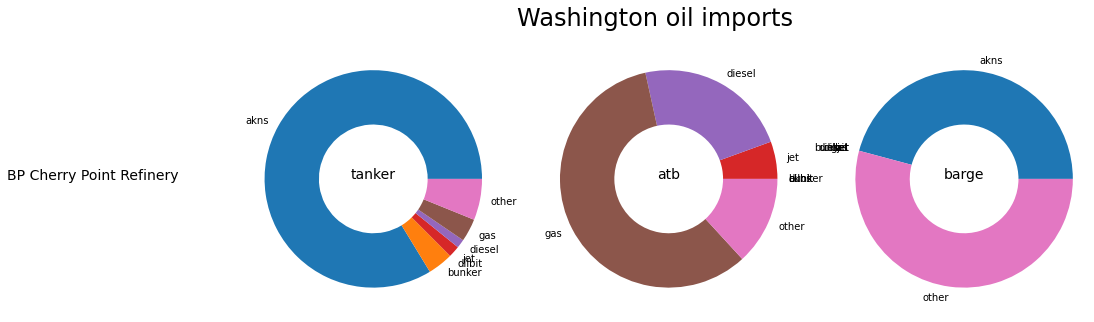

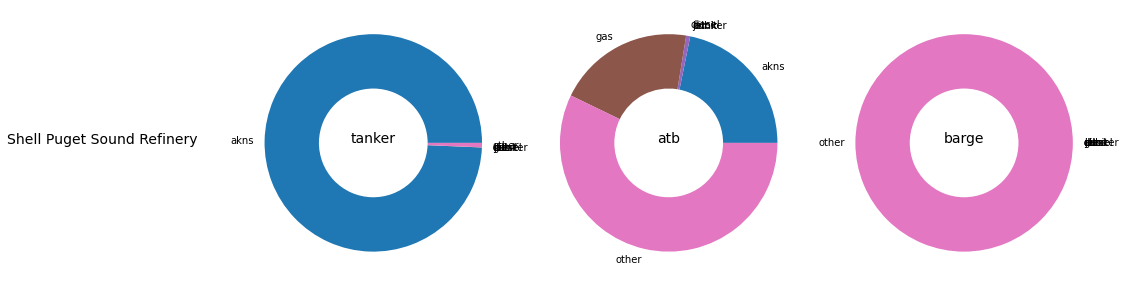

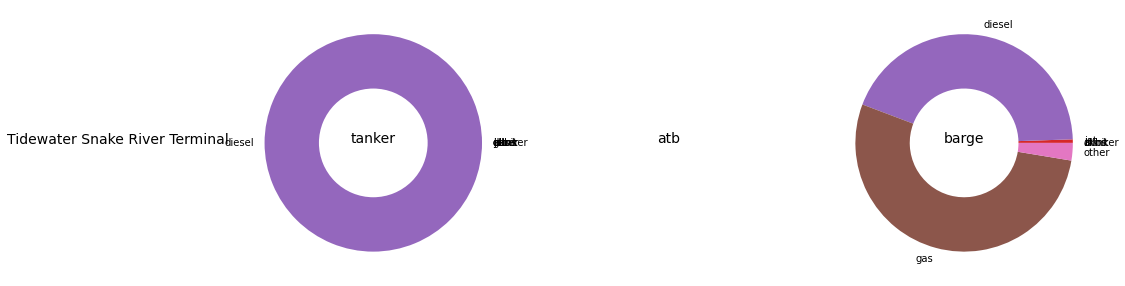

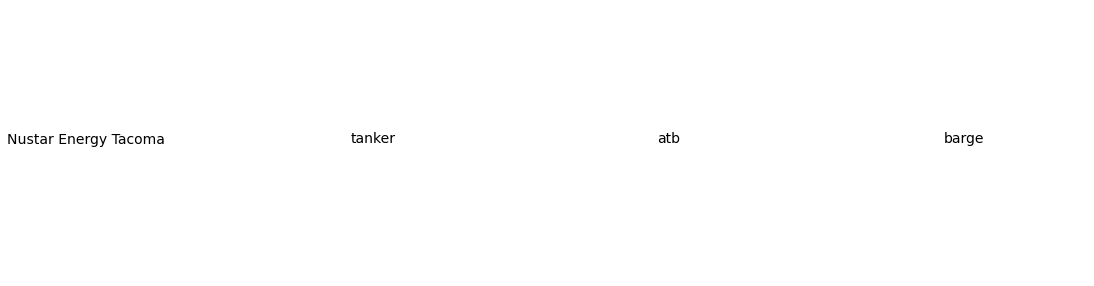

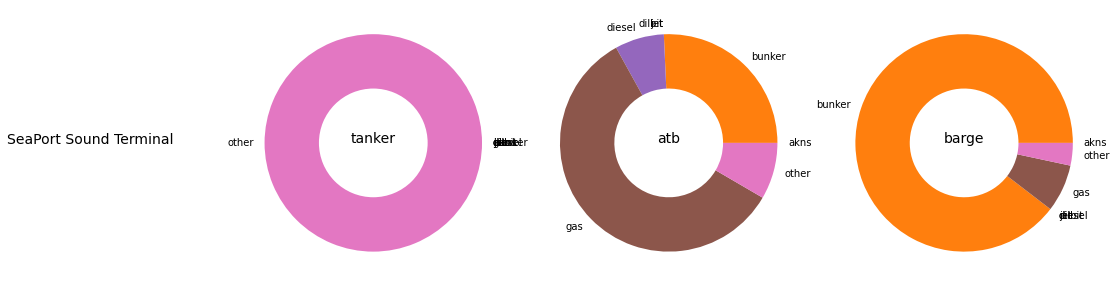

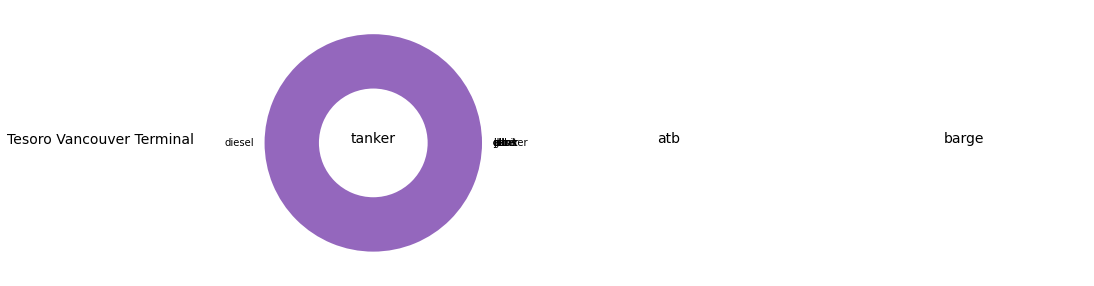

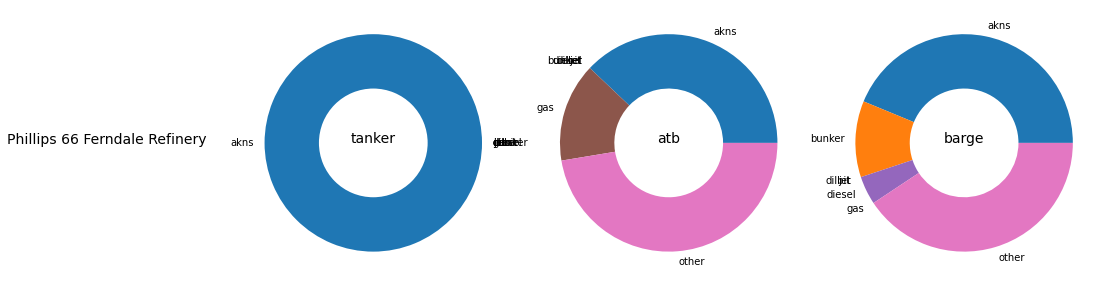

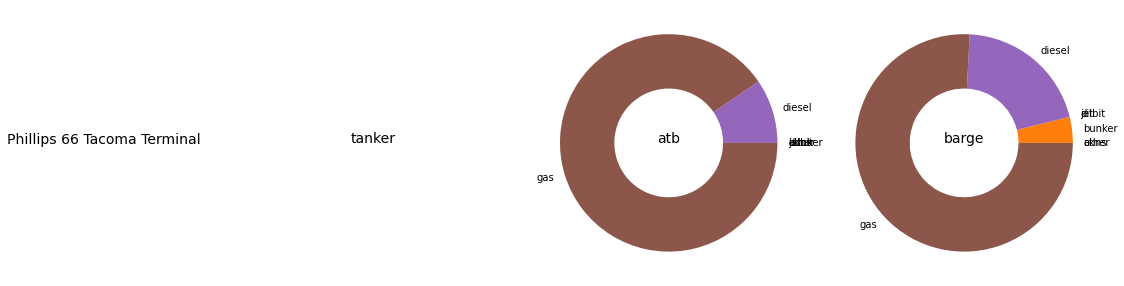

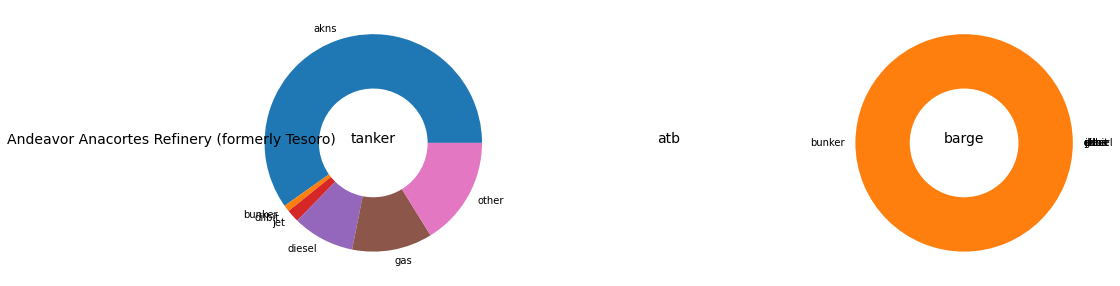

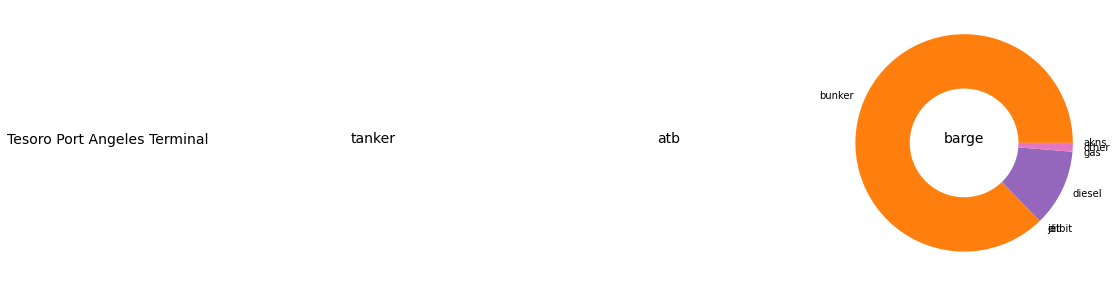

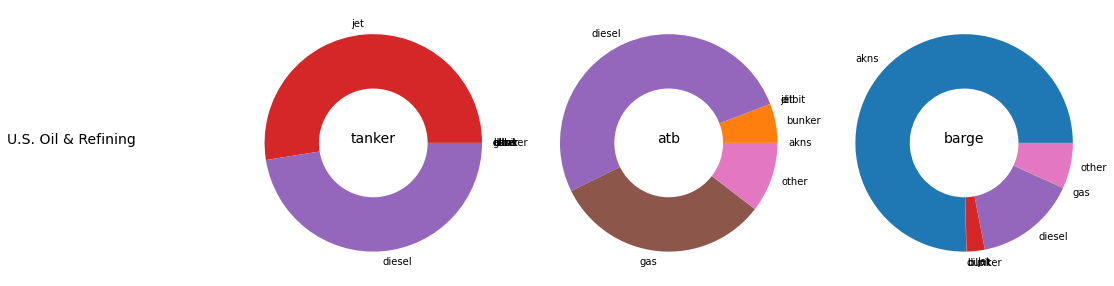

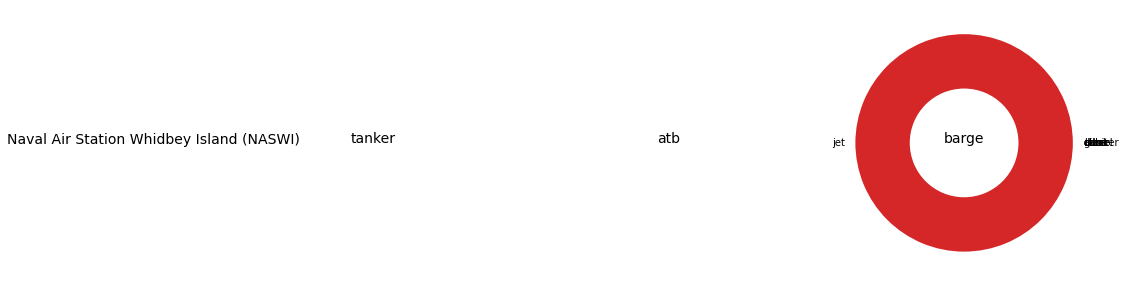

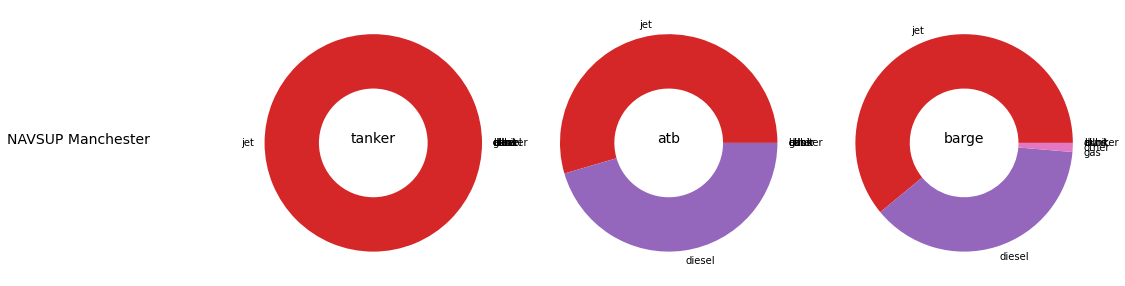

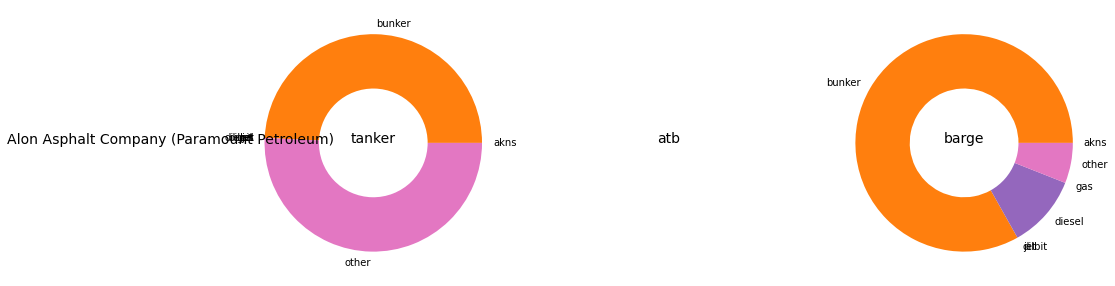

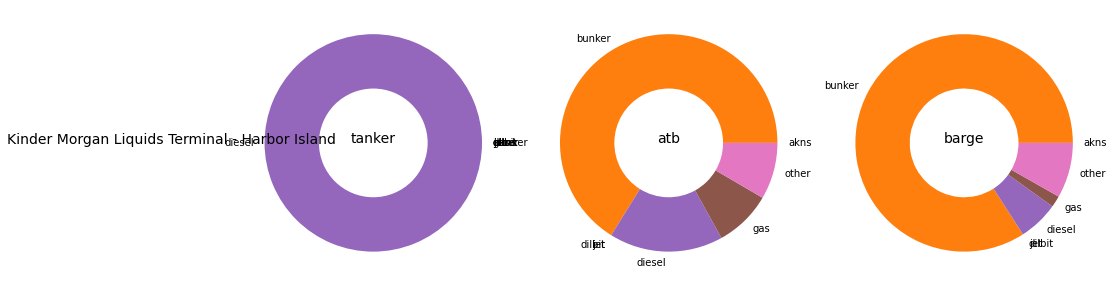

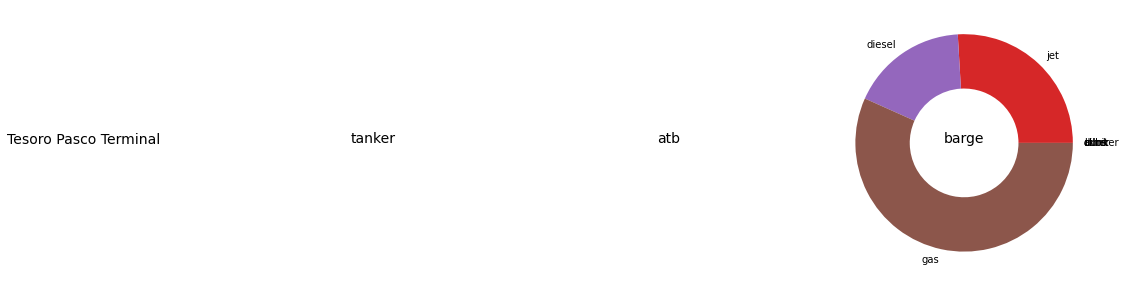

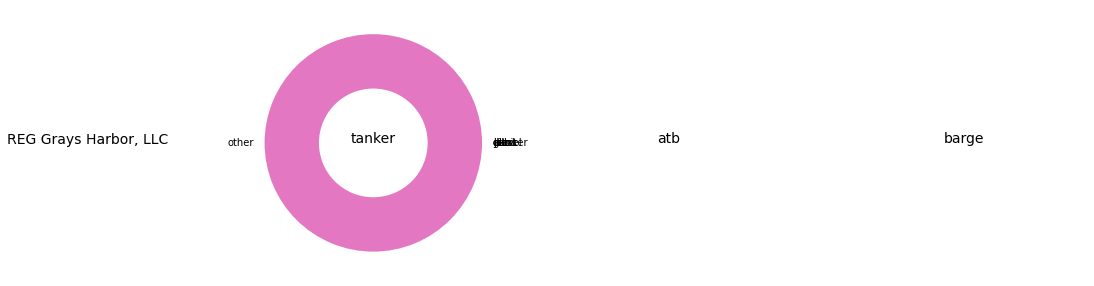

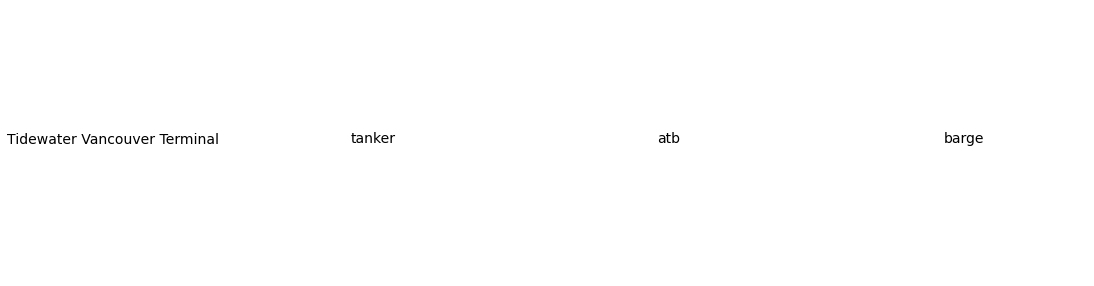

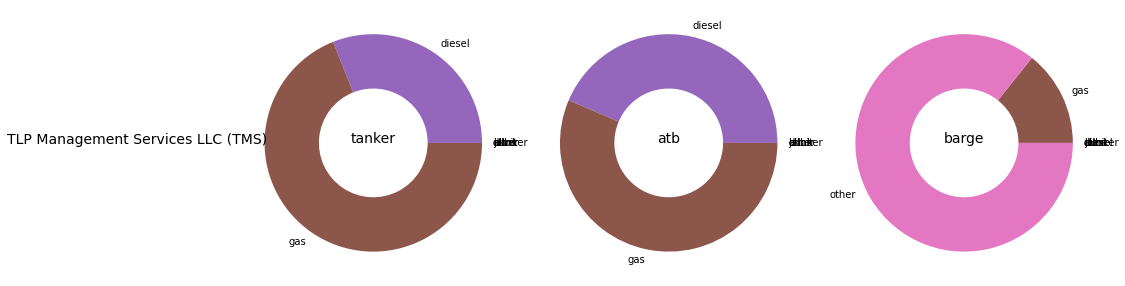

In [23]:
# axes are in a two-dimensional array, indexed by [row, col]
plot_array = np.empty(len(oil_types))

# Create a circle for the center of the plot
#my_circle=plt.Circle( (0,0), 0.7, color='white')

for i in range(len(destination['names'])):
    fig, axes = plt.subplots(1, len(vessel_types), figsize = (15,5))
    if i == 0:
        fig.suptitle('Washington oil imports',
                    fontsize = 24)
    facility = origin['names'][i]
    plt.text(-.1, 0.5, 
             facility, 
             ha='left',
             fontsize=14,
             wrap=True,
             transform=plt.gcf().transFigure)
    for j in range(len(vessel_types)):
        vessel = vessel_types[j]
        # create array of total oil volume by oil type for each vessel at each facility
        oil_index = 0
        for oil in oil_types:    
            plot_array[oil_index]=destination[facility][vessel][oil]['total_gallons']
            oil_index += 1
        
        axes[j].axis('equal')
        
        if plot_array.sum()>0:
            axes[j].pie(plot_array, wedgeprops=dict(width=0.5), labels = oil_types)
        else:
            axes[j].axis('off')
        axes[j].text(0,0,vessel,ha='center',fontsize=14)
       
          

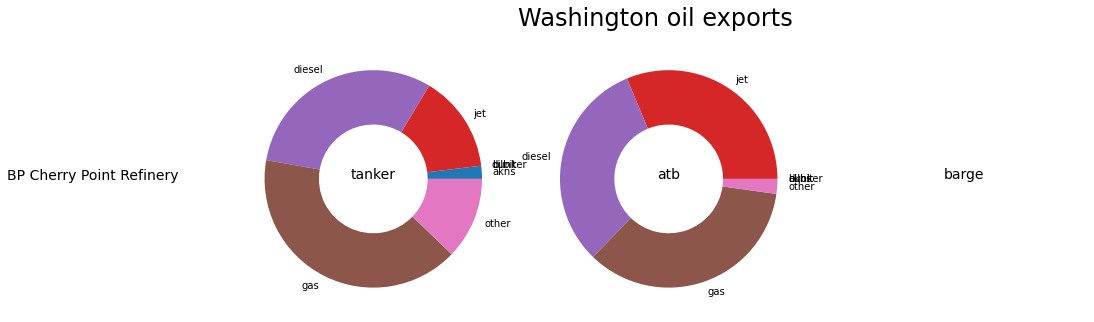

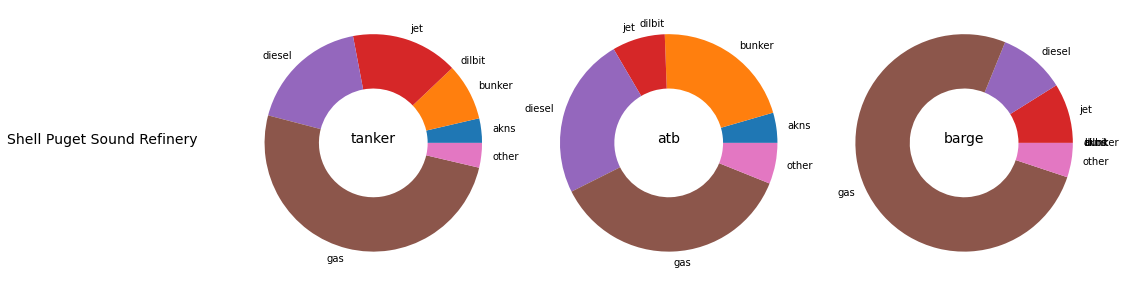

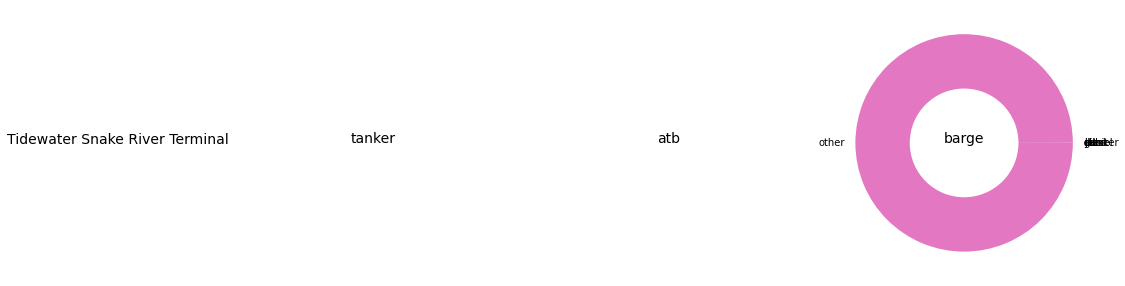

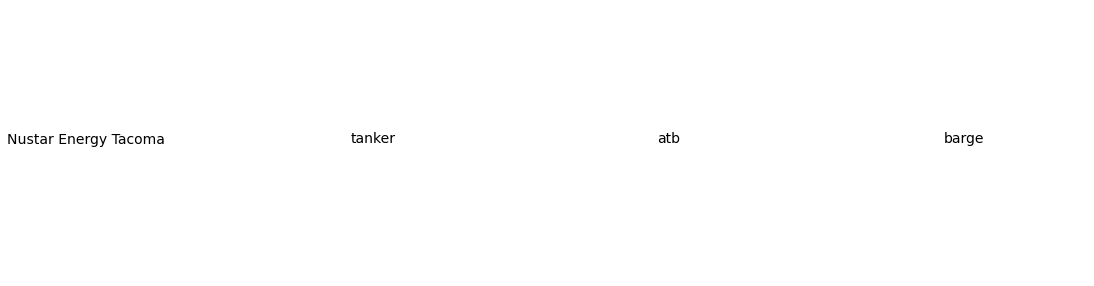

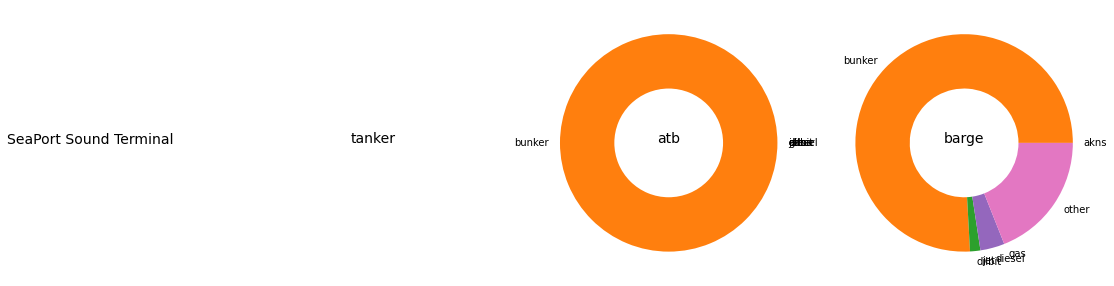

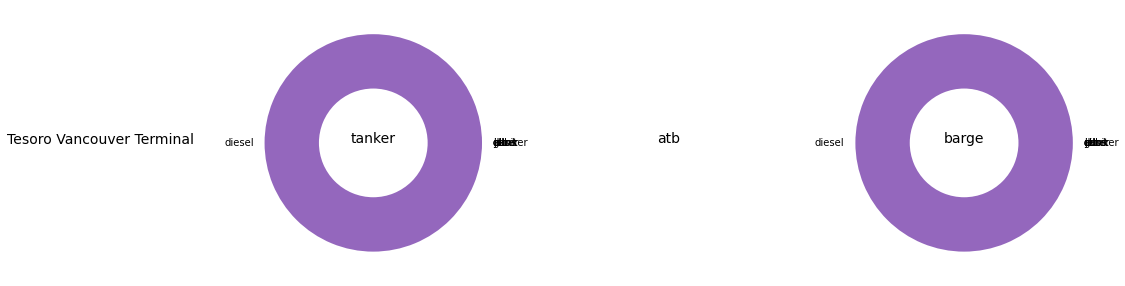

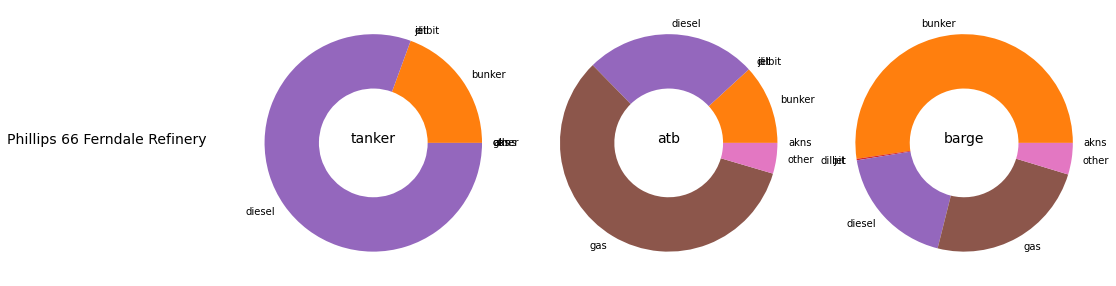

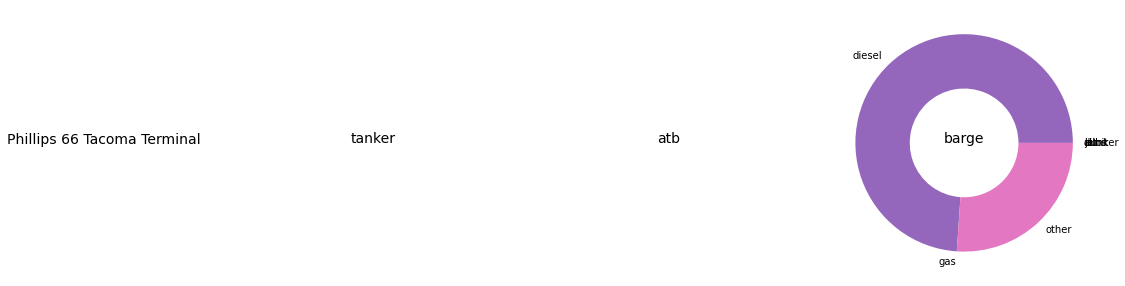

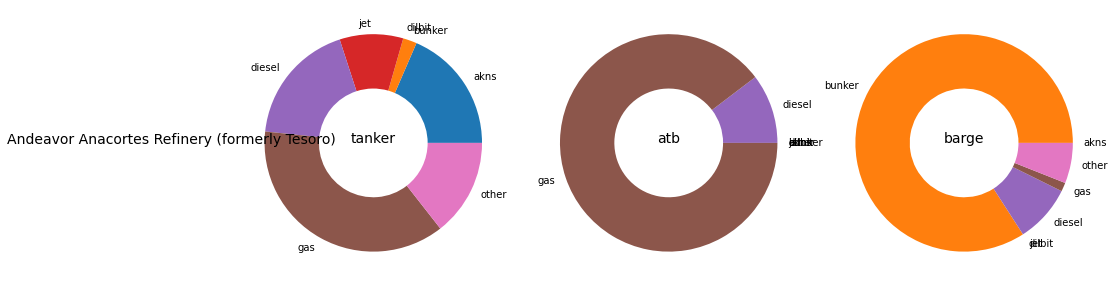

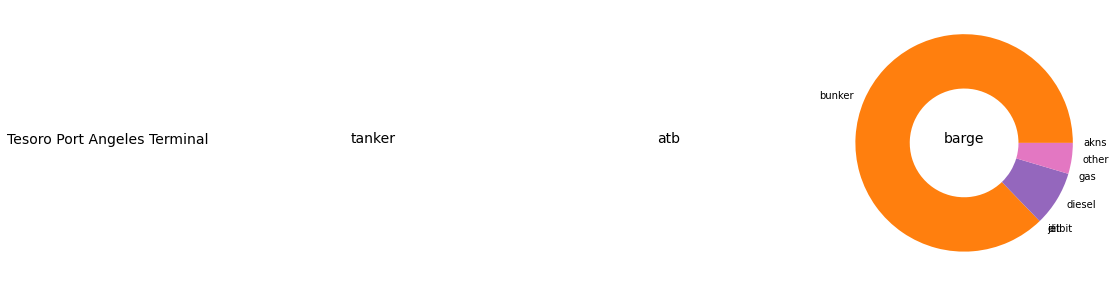

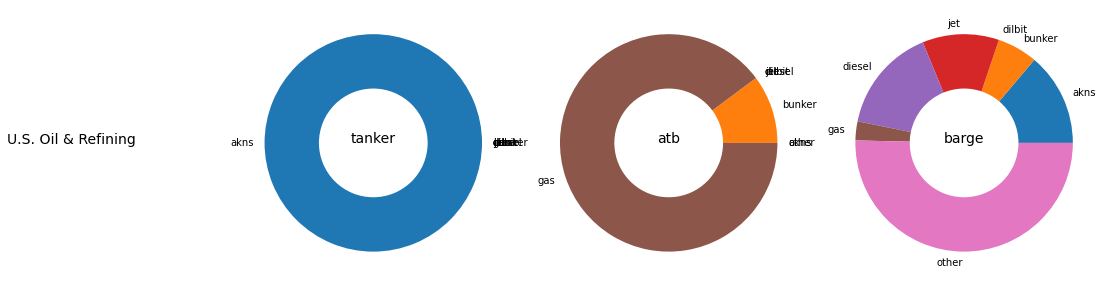

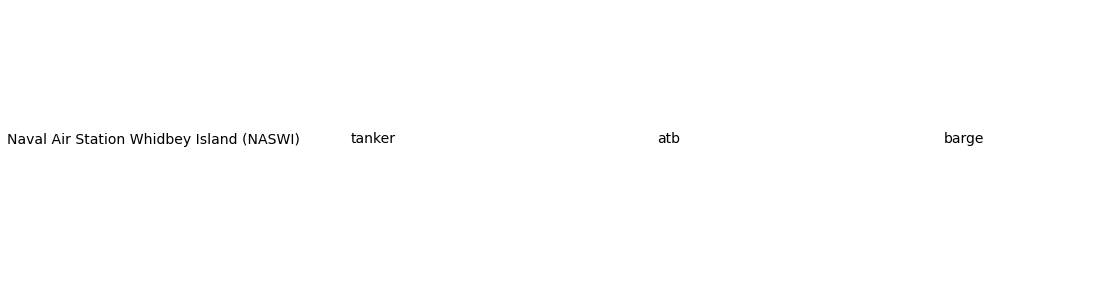

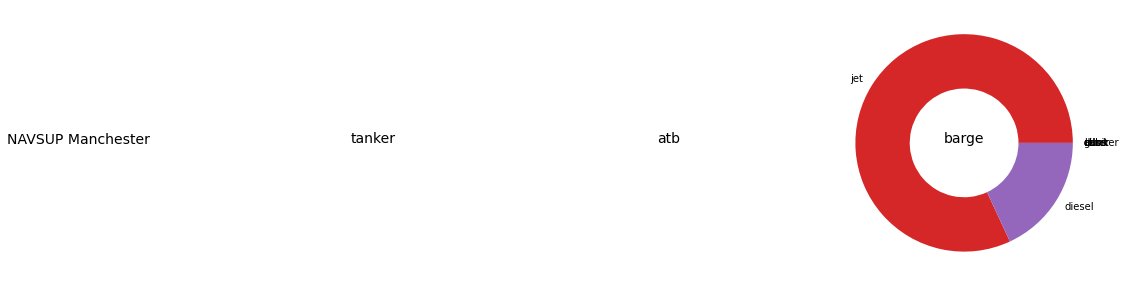

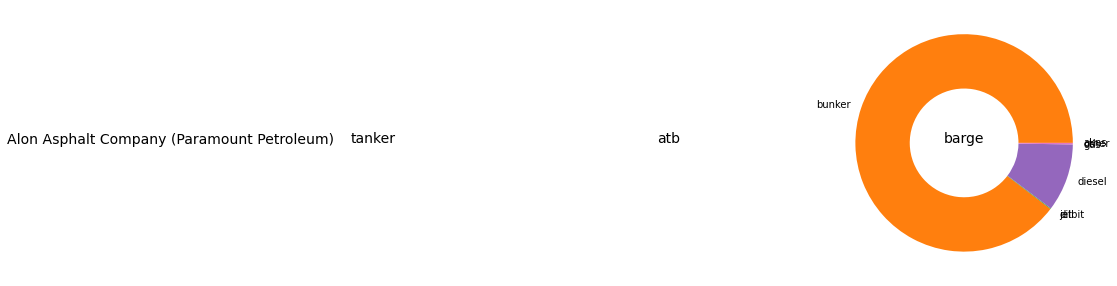

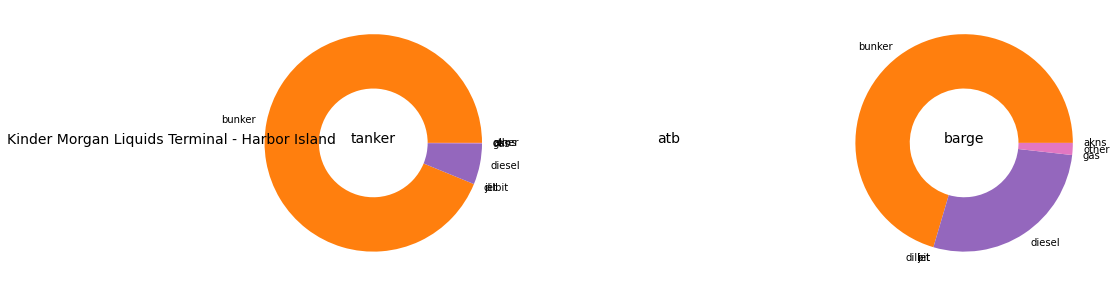

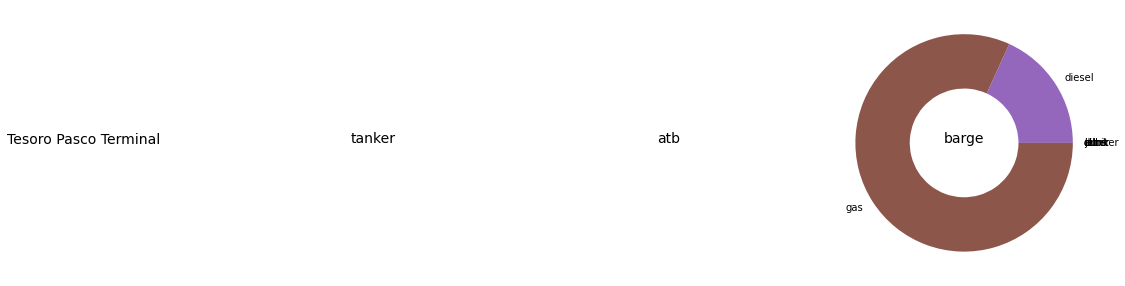

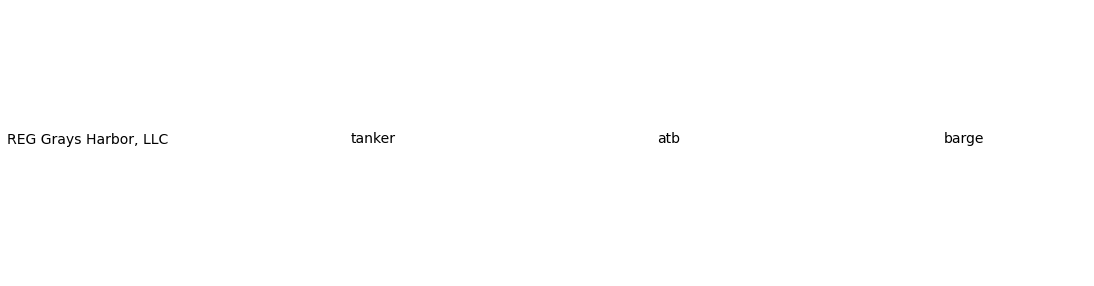

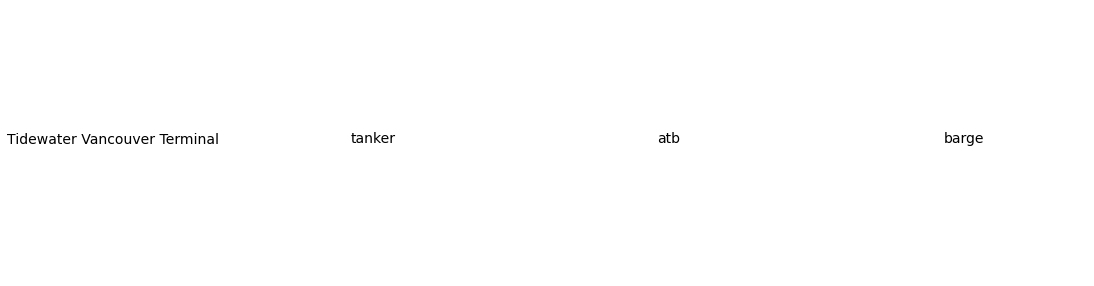

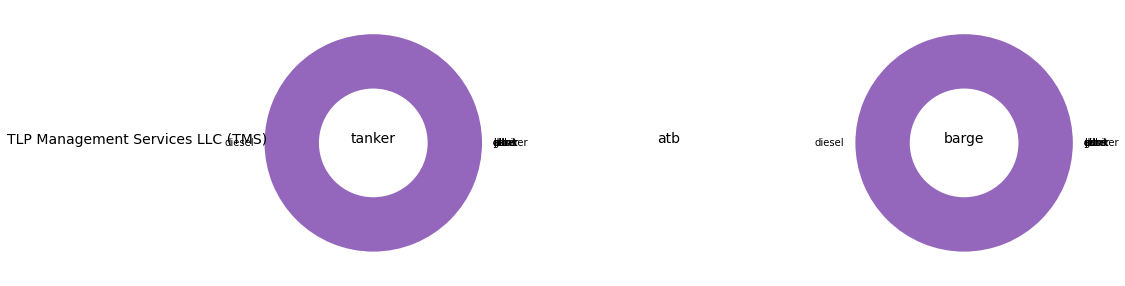

In [24]:
# axes are in a two-dimensional array, indexed by [row, col]
plot_array = np.empty(len(oil_types))

# Create a circle for the center of the plot
#my_circle=plt.Circle( (0,0), 0.7, color='white')

for i in range(len(origin['names'])):
    fig, axes = plt.subplots(1, len(vessel_types), figsize = (15,5))
    if i == 0:
        fig.suptitle('Washington oil exports',
                    fontsize = 24)
    facility = origin['names'][i]
    plt.text(-.1, 0.5, 
             facility, 
             ha='left',
             fontsize=14,
             wrap=True,
             transform=plt.gcf().transFigure)
    for j in range(len(vessel_types)):
        vessel = vessel_types[j]
        # create array of total oil volume by oil type for each vessel at each facility
        oil_index = 0
        for oil in oil_types:    
            plot_array[oil_index]=origin[facility][vessel][oil]['total_gallons']
            oil_index += 1
        
        axes[j].axis('equal')
        
        if plot_array.sum()>0:
            axes[j].pie(plot_array, wedgeprops=dict(width=0.5), labels = oil_types)
        else:
            axes[j].axis('off')
        axes[j].text(0,0,vessel,ha='center',fontsize=14)
       
            
